### I plan to build a 5-layers Sequential Convolutional Neural Network model. This model will be implemented by Keras API with Tensorflow as backend.

### In addition, I trained an ensemble model. This idea comes from voting. When you apply several CNN models, the classification result is clearly better than the single model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
# convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
# load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Data Visualization, to see the classification problem is whether balanced or not

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

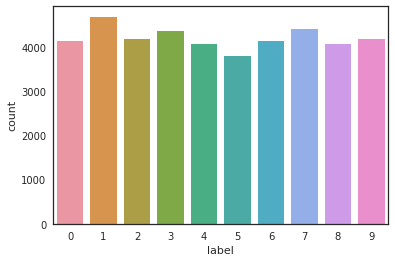

In [3]:
Y_train = train["label"]

# drop 'label' column
X_train = train.drop(labels=["label"], axis=1)

# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

In [4]:
# check for null and missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## normalization

In [6]:
# normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [7]:
# reshape image in 3 dimensions(height=28px. width=28px, canal=1)
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

### train and test images have been stored in pandas.Dataframe as 1D vector of 784 values.

In [8]:
# encode labels to one hot vectors
Y_train = to_categorical(Y_train, num_classes=10)

In [9]:
# set the random seed
random_seed=2

# split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

In [10]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

### This CNN model is classical CNN model.

### Conv layer and BatchNormalization layer crossover, BatchNormalization helps reduces the probability of overfitting

### Adding the dropout layer is essential step, it helps simulate the sampling method, thus to reduce overfitting

In [22]:
# Set the CNN model 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, strides = 2, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

### Define the train parameters

### We used the simulated annealing method ato decide the learning rate. Simulated annealing is classical numerical optimization method. Its performance is generally better than simply assign a static learning rate

In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-09, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 45
batch_size = 86

## data augmentation

### In this step, we used distortion idea to simulate more training data. Its performance is excellent. Not only do we increase the size of the training set, but also our neural network has better generalization ability.

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [25]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 7s - loss: 0.4204 - acc: 0.8702 - val_loss: 0.0727 - val_acc: 0.9795
Epoch 2/30
 - 6s - loss: 0.1174 - acc: 0.9642 - val_loss: 0.0633 - val_acc: 0.9829
Epoch 3/30
 - 6s - loss: 0.0931 - acc: 0.9725 - val_loss: 0.0442 - val_acc: 0.9879
Epoch 4/30
 - 6s - loss: 0.0727 - acc: 0.9783 - val_loss: 0.0363 - val_acc: 0.9883
Epoch 5/30
 - 6s - loss: 0.0691 - acc: 0.9787 - val_loss: 0.0233 - val_acc: 0.9924
Epoch 6/30
 - 6s - loss: 0.0612 - acc: 0.9820 - val_loss: 0.0384 - val_acc: 0.9910
Epoch 7/30
 - 7s - loss: 0.0604 - acc: 0.9821 - val_loss: 0.0213 - val_acc: 0.9931
Epoch 8/30
 - 6s - loss: 0.0534 - acc: 0.9843 - val_loss: 0.0235 - val_acc: 0.9924
Epoch 9/30
 - 6s - loss: 0.0511 - acc: 0.9848 - val_loss: 0.0272 - val_acc: 0.9919
Epoch 10/30
 - 6s - loss: 0.0488 - acc: 0.9860 - val_loss: 0.0230 - val_acc: 0.9931

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/30
 - 7s - loss: 0.0387 - acc: 0.9884 - val_loss: 0.0201 - val_acc: 0.9945
Epoc

### This performance is 0.99700

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [27]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

### try ensemble method, ensemble 15 CNNs

In [14]:
nets = 15
model = [0]*nets
for j in range(nets):
    model[j] = Sequential()
    
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])    

In [15]:
gen = ImageDataGenerator(rotation_range=10,
                        zoom_range=0.10,
                        width_shift_range=0.1,
                        height_shift_range=0.1)

In [16]:
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [25]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 20
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(gen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN 1: Epochs=20, Train accuracy=0.99635, Validation accuracy=0.99841
CNN 2: Epochs=20, Train accuracy=0.99685, Validation accuracy=0.99656
CNN 3: Epochs=20, Train accuracy=0.99614, Validation accuracy=0.99894
CNN 4: Epochs=20, Train accuracy=0.99658, Validation accuracy=0.99815
CNN 5: Epochs=20, Train accuracy=0.99673, Validation accuracy=0.99735
CNN 6: Epochs=20, Train accuracy=0.99682, Validation accuracy=0.99788
CNN 7: Epochs=20, Train accuracy=0.99635, Validation accuracy=0.99762
CNN 8: Epochs=20, Train accuracy=0.99647, Validation accuracy=0.99868
CNN 9: Epochs=20, Train accuracy=0.99552, Validation accuracy=0.99762
CNN 10: Epochs=20, Train accuracy=0.99491, Validation accuracy=0.99656
CNN 11: Epochs=20, Train accuracy=0.99499, Validation accuracy=0.99709
CNN 12: Epochs=20, Train accuracy=0.99479, Validation accuracy=0.99735
CNN 13: Epochs=20, Train accuracy=0.99462, Validation accuracy=0.99762
CNN 14: Epochs=20, Train accuracy=0.99476, Validation accuracy=0.99762
CNN 15: Epochs=

In [26]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

### This performance is 0.99728 Best so far